# Figures and tables for manuscript
Created by Ivan Lima on Thu Jan 21 2021 10:27:14 -0500

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime, warnings
from matplotlib import colors
from mpl_utils import center_cmap
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Mon Jul 26 22:33:48 2021


In [2]:
import seaborn as sns
rc_params = {'figure.dpi':100, 'axes.edgecolor':'#000000', 'axes.linewidth':0.8,
             'xtick.bottom':True, 'ytick.left':True}
sns.set_theme(context='paper', style='whitegrid', palette='tab10', rc=rc_params)
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 30
dpi = 600

## Read NSF-OCE award data

In [3]:
data_types = {'Abstract':'string', 'Title':'string', 'Programs':'string', 'PI':'string',
              'Organization':'string', 'State':'string', 'Instrument':'string', 'co-PIs':'string',
              'program':'string', 'PI_first_name':'string', 'co-PI_first_name':'string',
              'PI_gender':'string', 'co-PI_gender':'string', 'award_type':'string'}
awards = pd.read_csv('results/awards_1985-2020_clean_edited_grouped_gender_topic.csv', index_col=0,
                     parse_dates=[4,5], dtype=data_types)
awards['year'] = awards.StartDate.dt.year
awards.loc[awards.program=='DATA NOT AVAILABLE','program'] = np.nan
awards['co-PI_female_pct'] = awards['co-PI_female_frac'] * 100

npzfile = np.load('results/NMF_TSNE.npz')
topic_names    = npzfile['topic_names']
topic_names_r  = npzfile['topic_names_r']
npzfile.close()

# Read geosciences/atmospheric/ocean sciences academic gender workforce data
workforce = pd.read_csv('data/nsf_workforce.csv')#, index_col=0)
workforce['female_frac'] = workforce.female/workforce.total
workforce['female_pct'] = workforce['female_frac'] * 100

## Main Manuscript 

### Temporal trends in women's representation

Time series of the annual mean percentage of women PIs, co-PIs in NSF-OCE awards and women in the academic workforce in the fields of earth, atmospheric and ocean sciences. The lines represent the linear regression fits for each category (PI, co-PI and academic workforce). The gray line represents the linear regression fit for the combined PI and co-PI data. The parameter values for the different linear regression fits are shown in the table below. The academic workforce data was obtained from NSF’s Survey of Doctoral Recipients (SDR). The SDR is a biennial survey conducted through the National Center for Science and Engineering Statistics (NCSES) that provides demographic information about individuals with a doctoral degree in a science, engineering or health field from a U.S. academic institution.

The difference between the slopes for PIs, co-PIs and workforce is not statistically significant. The somewhat lower percentage of women in the workforce is most likely a result of the inclusion of earth and atmospheric sciences in the workforce data (in addition to ocean sciences). Thus, we assume that the temporal trends we see in the percentage of female PIs and co-PIs in NSF awards represent the increasing participation of females in the ocean sciences academic workforce.

,R^2,slope,intercept,p-value
PI,0.878,0.598,-1178.204,0.000000
co-PI,0.804,0.675,-1331.604,0.000000
PI + co-PI,0.829,0.636,-1254.904,0.000000
workforce,0.994,0.688,-1362.060,0.000000


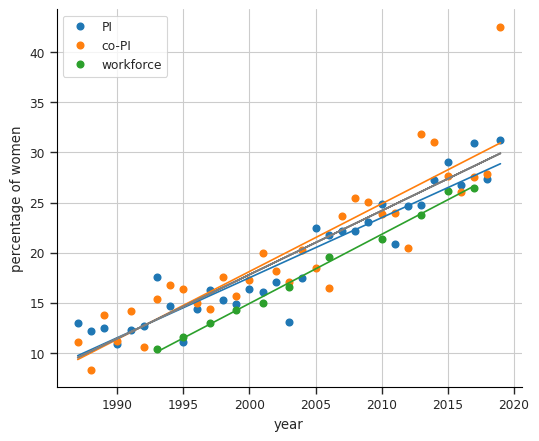

In [4]:
# female & male fraction of PIs
pi_gender = awards.groupby([awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender = pi_gender.divide(pi_gender.sum(axis=1), axis=0) * 100 # fraction -> percentage

# female & male fraction of co-PIs
copi_gender = pd.DataFrame({'female':awards.groupby(awards.StartDate.dt.year)['co-PI_female_frac'].mean()})
copi_gender['male'] = 1 - copi_gender.female
copi_gender = copi_gender * 100 # fraction -> percentage

# female percentage of PIs & co-PIs
female_pct = pd.DataFrame({'PI':pi_gender['female'], 'co-PI':copi_gender['female']})
female_pct.index.rename('year',inplace=True)

# combine PI & co-PI data
df_combined = pd.concat([pi_gender, copi_gender]).reset_index()
df_combined = df_combined.rename(columns={'index':'year'})

f_error = lambda x: 1.96 * x.std()/np.sqrt(x.size)
error = awards.groupby(awards.StartDate.dt.year)['co-PI_female_frac'].apply(f_error)
alpha = 1

def linreg(x, y):
    X = sm.add_constant(x)
    lreg = sm.OLS(y,X).fit()
    return lreg, X

fig, ax = plt.subplots(figsize=(6,5))
_ = female_pct.PI.plot(ax=ax, style='C0o')
_ = female_pct['co-PI'].plot(ax=ax, style='C1o')
_ = workforce.plot(x='year', y='female_pct', ax=ax, style='C2o', legend=False)
_ = ax.set(ylabel='percentage of women')
_ = ax.legend(['PI','co-PI','workforce'])

params = []
for x, y, s in zip([female_pct.index, female_pct.index, df_combined.year, workforce.year],
                   [female_pct.PI, female_pct['co-PI'], df_combined.female, workforce.female_pct],['C0-','C1-','C7-','C2-']):
    reg, X = linreg(x, y)
    params.append([reg.rsquared,reg.params[1],reg.params[0],reg.pvalues[1]])
    _ = ax.plot(x, reg.predict(X), s, alpha=alpha)

sns.despine(fig)
fig.savefig('figures/pi_copi_workforce_regress.png',dpi=dpi,bbox_inches='tight')

lr_stats = pd.DataFrame(np.array(params), index=['PI','co-PI','PI + co-PI','workforce'],
                        columns=['R^2','slope','intercept','p-value'])
lr_stats.style.format('{:.3f}', subset=['R^2','slope','intercept'])

### Women's representation across top 10 programs

Scatter plot of the percentage of women PIs vs co-PIs for the 10 largest NSF-OCE programs (in number of awards) in three different 11-year periods. The dotted diagonal line represents the 1:1 ratio. The vertical and horizontal dashed lines represent the mean percentage of women in the academic workforce for that time period computed from the linear trend fitted to the combined PI and co-PI data for all programs (figure above). The programs in the upper right quadrant of each panel have higher women’s participation than the academic workforce for both PIs and co-PIs while those in the lower left quadrant have lower participation than the workforce for both PIs and co-PIs. For the programs in the lower right quadrant, women’s participation as PIs is higher than in the workforce but participation as co-PIs is lower than in the workforce. Conversely, for programs in the upper left quadrant, women’s participation as co-PIs is higher than in the workforce but participation as PIs is lower than in the workforce. The marker color represents the ratio between the percentage of awards allocated by women PIs and men PIs to that program. A ratio greater than one means that women PIs apportion a higher proportion of their awards to that program than men do, and vice-versa. The table below shows the numbers plotted in the figure.

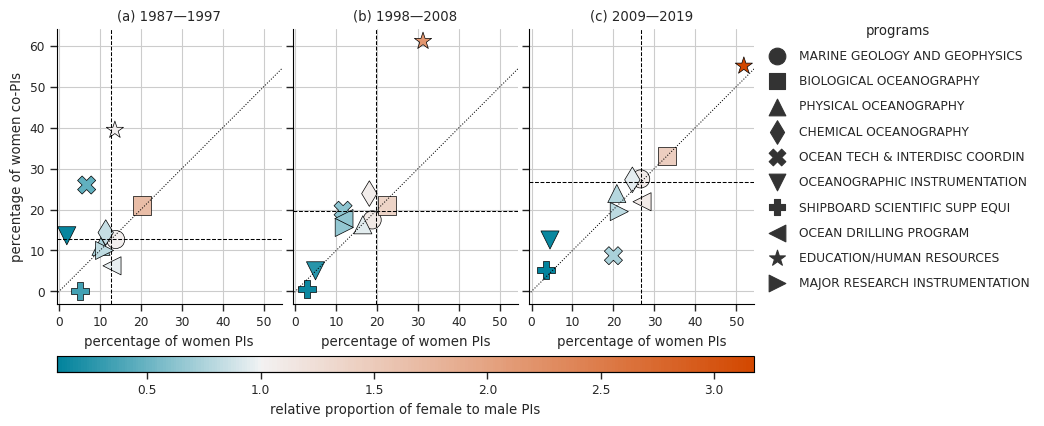

In [5]:
top10_programs = pd.DataFrame({'number of awards':
                               awards.groupby('program')['Abstract'].count().sort_values(ascending=False)[:10]})

awards_top10 = awards[awards.program.isin(top10_programs.index)] # awards in top 10 programs

awards_top10_1 = awards_top10[awards_top10.year<1998]                              # 1987-1997
awards_top10_2 = awards_top10[(awards_top10.year>1997) & (awards_top10.year<2009)] # 1998-2008
awards_top10_3 = awards_top10[awards_top10.year>2008]                              # 2009-2019 

def compute_pcts(df, grpvar):
    df_work_pi = df.groupby([grpvar,'PI_gender'])['Abstract'].count().unstack().fillna(0)
    # relative frequency distribution of NSF programs by PI gender
    df_freq = df_work_pi/df_work_pi.sum() * 100 # fraction -> percentage
    # PI gender percentage in the top 10 programs
    df_pi = df_work_pi.divide(df_work_pi.sum(axis=1), axis=0) * 100 # fraction -> percentage
    # co-PI gender percentage in the top 10 programs
    df_copi = pd.DataFrame({'female': df.groupby([grpvar])['co-PI_female_frac'].mean()})
    df_copi = df_copi.fillna(0) * 100 # fraction -> percentage
    return pd.DataFrame({'PI': df_pi.female,'co-PI':df_copi.female,'ratio': df_freq.female/df_freq.male})

by_prog1 = compute_pcts(awards_top10_1,'program').reindex(top10_programs.index)
by_prog2 = compute_pcts(awards_top10_2,'program').reindex(top10_programs.index)
by_prog3 = compute_pcts(awards_top10_3,'program').reindex(top10_programs.index)

# read reference/workforce data
wf_ref = pd.read_csv('results/gender_ref.csv')
wf_ref = wf_ref.drop('co-PI', axis=1)
wf_ref = wf_ref.rename(columns={'StartDate': 'year', 'PI':'workforce'})
wf_ref['workforce'] = wf_ref.workforce * 100 # fraction -> percentage

wf_ref_1 = wf_ref[wf_ref.year<1998]                        # 1987-1997
wf_ref_2 = wf_ref[(wf_ref.year>1997) & (wf_ref.year<2009)] # 1998-2008
wf_ref_3 = wf_ref[wf_ref.year>2008]                        # 2009-2019 

# compute period means for reference/workforce data
wf_means = [df['workforce'].mean() for df in [wf_ref_1, wf_ref_2, wf_ref_3]]

titles = [u'(a) 1987\u20141997',u'(b) 1998\u20142008',u'(c) 2009\u20142019']
markers = ['o','s','^','d','X','v','P','<','*','>']
vmin, vmax = by_prog3.ratio.min(), by_prog3.ratio.max()
# cmap = sns.diverging_palette(145, 300, s=75, as_cmap=True)
cmap = sns.diverging_palette(220, 20, s=100, as_cmap=True)
# cmap = sns.diverging_palette(145, 20, s=75, as_cmap=True)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9,4))
fig.subplots_adjust(wspace=0.05)
for ax, df, t , wf in zip(axs.ravel(),[by_prog1,by_prog2,by_prog3], titles, wf_means):
    _ = sns.scatterplot(x='PI', y='co-PI', data=df, hue='ratio', s=170, style=df.index, legend='brief',
                        ax=ax, palette=cmap, edgecolor='k', linewidth=0.5, markers=markers,
                        hue_norm=colors.TwoSlopeNorm(1, 0.1, vmax), alpha=1)
    _ = ax.axis('scaled')
    _ = ax.set(xlabel='percentage of women PIs', title=t, xticks=np.arange(0,60,10))
    _ = ax.get_legend().remove()

_ = axs[0].set(ylabel='percentage of women co-PIs')
xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()
for ax, wf in zip(axs, wf_means):
    _ = ax.plot([ymin,ymax], [ymin,ymax], ':', color='k', linewidth=0.75)
    _ = ax.hlines(wf, xmin, xmax, linestyles='dashed', colors='k', linewidth=0.75)
    _ = ax.vlines(wf, ymin, ymax, linestyles='dashed', colors='k', linewidth=0.75)

handles, labels = axs[0].get_legend_handles_labels()
_ = ax.legend(handles[7:], labels[7:], loc='upper left', bbox_to_anchor=(1.0, 1.06), frameon=False, labelspacing=1, title='programs', markerscale=2.5)

smap = plt.cm.ScalarMappable(cmap=cmap, norm=colors.TwoSlopeNorm(1, 0.1, vmax))
smap.set_array([])
l, b, w, h = axs[0].get_position().bounds
cax = fig.add_axes([l, b-0.17, 0.775, 0.04])
cb = fig.colorbar(smap, cax=cax, orientation='horizontal')
_ = cb.set_label('relative proportion of female to male PIs')

sns.despine(fig)
fig.savefig('figures/pi_copi_program_scatter.png',dpi=dpi,bbox_inches='tight')

cols = ['PI','co-PI','ratio']
pd.concat([by_prog1[cols], by_prog2[cols], by_prog3[cols]], keys=['1987-1997','1998-2008', '2009-2019'], axis=1).style.format('{:.2f}')

Workforce means for each time period.

In [6]:
pd.DataFrame(wf_means, index=['1987-1997','1998-2008','2009-2019'], columns=['workforce mean']).style.format('{:.2f}')

,workforce mean
1987-1997,12.73
1998-2008,19.73
2009-2019,26.73


### Women's representation across different research topics

Scatter plot of the percentage of women PIs vs co-PIs for 22 extracted research topics in three different 11-year periods. The dotted diagonal line represents the 1:1 ratio. The vertical and horizontal dashed lines represent the mean percentage of women in the academic workforce for that time period computed from the linear trend fitted to the combined PI and co-PI data for all programs (see regression figure above). The topics in the upper right quadrant of each panel have higher women’s participation than the academic workforce for both PIs and co-PIs while those in the lower left quadrant have lower participation than the workforce for both PIs and co-PIs. For the topics in the lower right quadrant, women’s participation as PIs is higher than in the workforce but participation as co-PIs is lower than in the workforce. Conversely, for topics in the upper left quadrant, women’s participation as co-PIs is higher than in the workforce but participation as PIs is lower than in the workforce. The marker color represents the ratio between the percentage of awards allocated by women PIs and men PIs to that topic. A ratio greater than one means that women PIs apportion a higher proportion of their awards to that topic than men do, and vice-versa. 
The topic legend text is colored according to the NSF-OCE program. Blue represents topics in Marine Geology and Geophysics and the Ocean Drilling Program, orange represents topics in Biological Oceanography, green represent topics in Physical Oceanography, red represents topics in Chemical Oceanography, purple represents topics associated with instrumentation development (OTIC and MRI), brown represents topics related to ship instrumentation and operations (OI and SSSE) and cyan represent topics in Education and Human Resources (EHR).

The table below shows the numbers plotted in the figure.

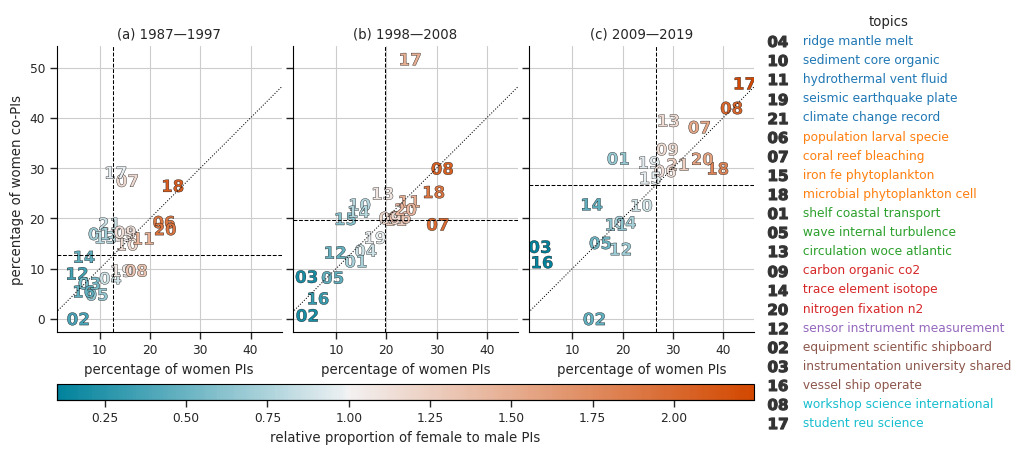

In [7]:
from matplotlib.colors import ListedColormap

tab20 = plt.cm.get_cmap('tab20')
newcmap = tab20.colors + ((1,1,0.0),) + ((0,0,0),)
tab22 = ListedColormap(newcmap,'tab22')

awards_1 = awards[awards.year<1998]                        # 1987-1997
awards_2 = awards[(awards.year>1997) & (awards.year<2009)] # 1998-2008
awards_3 = awards[awards.year>2008]                        # 2009-2019

by_topic_1 = compute_pcts(awards_1,'topic')
by_topic_2 = compute_pcts(awards_2,'topic')
by_topic_3 = compute_pcts(awards_3,'topic')

topic_map = {t+1:topic_names_r[t][2:] for t in range(len(topic_names_r))}
reorder = np.array([4,10,11,19,21,6,7,15,18,1,5,13,9,14,20,12,2,3,16,8,17]) # order topics by program
by_topic_1 = by_topic_1.reindex(reorder)
by_topic_2 = by_topic_2.reindex(reorder)
by_topic_3 = by_topic_3.reindex(reorder)
for df in [by_topic_1, by_topic_2, by_topic_3]:
    df.index = df.index.map(topic_map)

topic_markers = [r'$\mathbf{%02d}$'%(i) for i in reorder]
vmin, vmax = by_topic_3.ratio.min(), by_topic_3.ratio.max()

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9,4))
fig.subplots_adjust(wspace=0.05)
for ax, df, t , wf in zip(axs.ravel(),[by_topic_1, by_topic_2, by_topic_3], titles, wf_means):
    _ = sns.scatterplot(x='PI', y='co-PI', data=df, hue='ratio', s=250, style=df.index, legend='brief',
                        ax=ax, palette=cmap, edgecolor='k', linewidth=0.25, markers=topic_markers,
                        hue_norm=colors.TwoSlopeNorm(1, vmin, vmax), alpha=alpha)
    _ = ax.axis('scaled')
    _ = ax.set(xlabel='percentage of women PIs', title=t)
    _ = ax.get_legend().remove()

_ = axs[0].set(ylabel='percentage of women co-PIs')
xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()
for ax, wf in zip(axs, wf_means):
    _ = ax.plot([ymin,ymax], [ymin,ymax] , ':', color='k', linewidth=0.75)
    _ = ax.hlines(wf, xmin, xmax, linestyles='dashed', colors='k', linewidth=0.75)
    _ = ax.vlines(wf, ymin, ymax, linestyles='dashed', colors='k', linewidth=0.75)

handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles[7:], labels[7:], loc='upper left', bbox_to_anchor=(1.0, 1.15), frameon=False, markerscale=3, title='topics')

# color topic legend text according to program
lg = ax.get_legend()
texts = lg.get_texts()
for text in texts[0:5]:
    text.set_color('C0')
for text in texts[5:9]:
    text.set_color('C1')
for text in texts[9:12]:
    text.set_color('C2')
for text in texts[12:15]:
    text.set_color('C3')
for text in texts[15:16]:
    text.set_color('C4')
for text in texts[16:19]:
    text.set_color('C5')
for text in texts[19:]:
    text.set_color('C9')

smap = plt.cm.ScalarMappable(cmap=cmap, norm=colors.TwoSlopeNorm(1, vmin, vmax))
smap.set_array([])
l, b, w, h = axs[0].get_position().bounds
cax = fig.add_axes([l, b-0.17, 0.775, 0.04])
cb = fig.colorbar(smap, cax=cax, orientation='horizontal')
_ = cb.set_label('relative proportion of female to male PIs')

sns.despine(fig)
fig.savefig('figures/pi_copi_topic_scatter.png',dpi=dpi,bbox_inches='tight')

by_topic = pd.concat([by_topic_1[cols], by_topic_2[cols], by_topic_3[cols]], keys=['1987-1997','1998-2008', '2009-2019'], axis=1)
by_topic.style.format('{:.2f}')

### Women's representation across different award types

Types of awards and initiatives identified in the data include:

- Collaborative Research
- EAGER: EArly-concept Grant For Exploratory Research
- RAPID: Rapid Response Research
- REU: Research Experience for Undergraduates
- RUI: Research in Undergraduate Institutions
- SGER: Small Grants for Exploratory Research
- CAREER: Faculty Early Career Development
- CMG: Collaboration in Mathematical Geosciences
- POWRE: Professional Opportunities for Women in Research and Education

SGER is an older type of award (~2003) that seems to be a combination of EAGER and RAPID, but more like EAGER. Therefore we are grouping these two types of awards together as EAGER awards. *Professional Opportunities for Women in Research and Education* (POWRE) is an award type exclusive for women and there are only 13 awards of this type so it was removed from the analysis. *Collaboration in Mathematical Geosciences* (CMG): There are only 20 awards of this type, so it was also removed from the analysis.

Scatter plot of the percentage of women PIs vs co-PIs for the different award types in three different 11-year periods. The dotted diagonal line represents the 1:1 ratio. The vertical and horizontal dashed lines represent the mean percentage of women in the academic workforce for that time period computed from the linear trend fitted to the combined PI and co-PI data for all programs (see regression figure above). The award types in the upper right quadrant of each panel have higher women’s participation than the academic workforce for both PIs and co-PIs while those in the lower left quadrant have lower participation than the workforce for both PIs and co-PIs. For the award types in the lower right quadrant, women’s participation as PIs is higher than in the workforce but participation as co-PIs is lower than in the workforce. Conversely, for award types in the upper left quadrant, women’s participation as co-PIs is higher than in the workforce but participation as PIs is lower than in the workforce. The marker color represents the ratio between the percentage of awards allocated by women PIs and men PIs to that award type. A ratio greater than one means that women PIs apportion a higher proportion of their awards to that award type than men do, and vice-versa. The table below shows the numbers plotted in the figure.

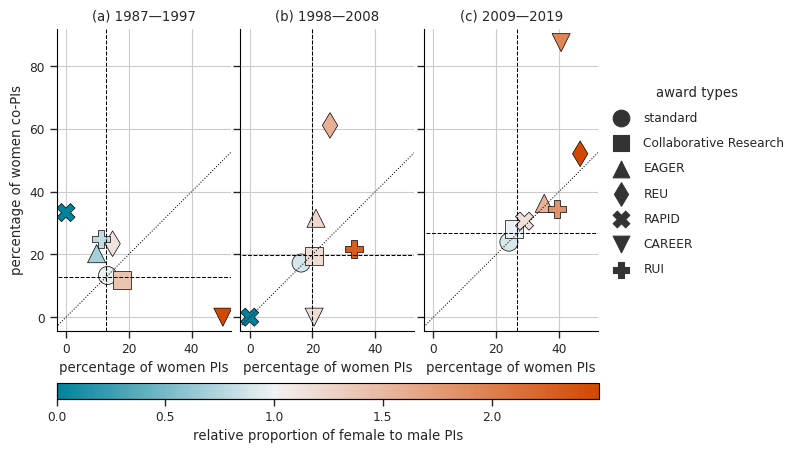

In [8]:
awards_clean = awards[awards.award_type!='CMG']
awards_clean = awards_clean[awards_clean.award_type!='POWRE']

atypes = pd.DataFrame({'number of awards': awards_clean.award_type.value_counts()}) # number of awards in each type

by_atype_1 = compute_pcts(awards_1,'award_type')
by_atype_2 = compute_pcts(awards_2,'award_type')
by_atype_3 = compute_pcts(awards_3,'award_type')

by_atype_1 = by_atype_1.reindex(atypes.index).fillna(0)
by_atype_2 = by_atype_2.reindex(atypes.index).fillna(0)
by_atype_3 = by_atype_3.reindex(atypes.index).fillna(0)

# vmin, vmax = 0, by_atype_1.ratio.max()
vmin, vmax = 0, by_atype_3.ratio.max()

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(7,4))
fig.subplots_adjust(wspace=0.05)
for ax, df, t , wf in zip(axs.ravel(),[by_atype_1, by_atype_2, by_atype_3], titles, wf_means):
    _ = sns.scatterplot(x='PI', y='co-PI', data=df, hue='ratio', s=170, style=df.index, legend='brief',
                        ax=ax, palette=cmap, edgecolor='k', linewidth=0.5, markers=markers[:7],
                        hue_norm=colors.TwoSlopeNorm(1, vmin, vmax), alpha=1)
    _ = ax.axis('scaled')
    _ = ax.set(xlabel='percentage of women PIs', title=t)
    _ = ax.get_legend().remove()

_ = axs[0].set(ylabel='percentage of women co-PIs')
xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()
for ax, wf in zip(axs, wf_means):
    _ = ax.plot([ymin,ymax], [ymin,ymax], ':', color='k', linewidth=0.75)
    _ = ax.hlines(wf, xmin, xmax, linestyles='dashed', colors='k', linewidth=0.75)
    _ = ax.vlines(wf, ymin, ymax, linestyles='dashed', colors='k', linewidth=0.75)
    _ = ax.set_xlim(-3,xmax)

handles, labels = axs[0].get_legend_handles_labels()
_ = ax.legend(handles[5:], labels[5:], loc='upper left', bbox_to_anchor=(1.0, 0.85), frameon=False, labelspacing=1, title='award types', markerscale=2.5)

smap = plt.cm.ScalarMappable(cmap=cmap, norm=colors.TwoSlopeNorm(1, vmin, vmax))
smap.set_array([])
l, b, w, h = axs[0].get_position().bounds
cax = fig.add_axes([l, b-0.17, 0.775, 0.04])
cb = fig.colorbar(smap, cax=cax, orientation='horizontal')
_ = cb.set_label('relative proportion of female to male PIs')

sns.despine(fig)
fig.savefig('figures/pi_copi_atype_scatter.png',dpi=dpi,bbox_inches='tight')

pd.concat([by_atype_1[cols], by_atype_2[cols], by_atype_3[cols]], keys=['1987-1997','1998-2008', '2009-2019'], axis=1).style.format('{:.2f}')

Number of awards in each period.

In [9]:
df = pd.DataFrame({'1987-1997': awards_1.award_type.value_counts(),
                   '1998-2008': awards_2.award_type.value_counts(),
                   '2009-2019': awards_3.award_type.value_counts()})
df.reindex(awards_clean.award_type.value_counts().index)

,1987-1997,1998-2008,2009-2019
standard,3685,2731,2084
Collaborative Research,145,852,991
EAGER,82,180,87
REU,101,43,92
RAPID,4,4,203
CAREER,10,39,59
RUI,36,24,28


## Supplementary Materials 

Percentage change in women’s participation in NSF-OCE awards between 1987–1997 and 2009–2019 for PIs co-PIs and the mean of the two for each topic.

In [10]:
df1 = pd.concat([by_topic_1[['PI']], by_topic_3[['PI']]], axis=1).diff(axis=1)
df1.index = topic_names
df2 = pd.concat([by_topic_1[['co-PI']], by_topic_3[['co-PI']]], axis=1).diff(axis=1)
df2.index = topic_names

topic_net_change = pd.concat([df1, df2], axis=1).dropna(axis=1)
topic_net_change['mean'] = topic_net_change.mean(axis=1)
topic_net_change.index.name = 'topic'
topic_net_change = topic_net_change.sort_values('mean', ascending=False).round(2)
topic_net_change.to_csv('results/topic_net_change.csv')
topic_net_change

,PI,co-PI,mean
topic,,,
nitrogen fixation n2 20,24.42,32.33,28.38
climate change record 21,31.09,17.76,24.43
sensor instrument measurement 12,17.96,23.22,20.59
ridge mantle melt 4,10.91,21.52,16.22
wave internal turbulence 5,19.09,11.80,15.45
coral reef bleaching 7,19.80,10.64,15.22
circulation woce atlantic 13,13.84,16.49,15.17
iron fe phytoplankton 15,12.84,13.98,13.41
sediment core organic 10,9.21,14.99,12.10


Number and percentage of awards in each award type for the period 1987–2019.

In [11]:
awards_clean = awards[awards.award_type!='POWRE']
awards_clean = awards_clean[awards_clean.award_type!='CMG']
atypes = pd.DataFrame({'number of awards': awards_clean.award_type.value_counts()})
atypes['percentage of total'] =  atypes['number of awards'] / len(awards) * 100
atypes['cum. percentage of total'] = atypes['percentage of total'].cumsum()
atypes.index.name = 'award type'
atypes.to_csv('results/atypes_pct_num.csv')
atypes.style.format('{:.2f}', subset=['percentage of total','cum. percentage of total'])

,number of awards,percentage of total,cum. percentage of total
award type,,,
standard,8500,73.83,73.83
Collaborative Research,1988,17.27,91.10
EAGER,349,3.03,94.13
REU,236,2.05,96.18
RAPID,211,1.83,98.01
CAREER,108,0.94,98.95
RUI,88,0.76,99.71


Amount awarded and percentage of total amount awarded for each award type for the period 1987–2019. Amounts are adjusted for inflation to 2019 U.S. dollars.

In [12]:
atypes_amount = pd.DataFrame({'amount awarded':
                             awards_clean.groupby('award_type')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
atypes_amount['percentage of total'] = (atypes_amount['amount awarded'] / awards['tot_amount_adjusted'].sum()
                                       * 100)
atypes_amount['cum. percentage of total'] = atypes_amount['percentage of total'].cumsum()
atypes_amount.to_csv('results/atypes_pct_amount.csv')
atypes_amount.style.format('${0:,.2f}', subset='amount awarded')

,amount awarded,percentage of total,cum. percentage of total
award_type,,,
standard,"$11,093,484,591.21",83.345371,83.345371
Collaborative Research,"$1,924,975,456.67",14.462344,97.807716
REU,"$102,516,226.11",0.770205,98.577920
CAREER,"$64,394,968.02",0.483800,99.061720
EAGER,"$42,089,704.65",0.316220,99.377940
RUI,"$36,333,626.48",0.272975,99.650914
RAPID,"$27,477,422.61",0.206438,99.857352


Time series of the annual percentage of the number of awards (a) and the amount awarded (b) for each award type between 1987 and 2019. The amounts awarded were adjusted for inflation to 2019 U.S. dollars prior to computing the percentages.

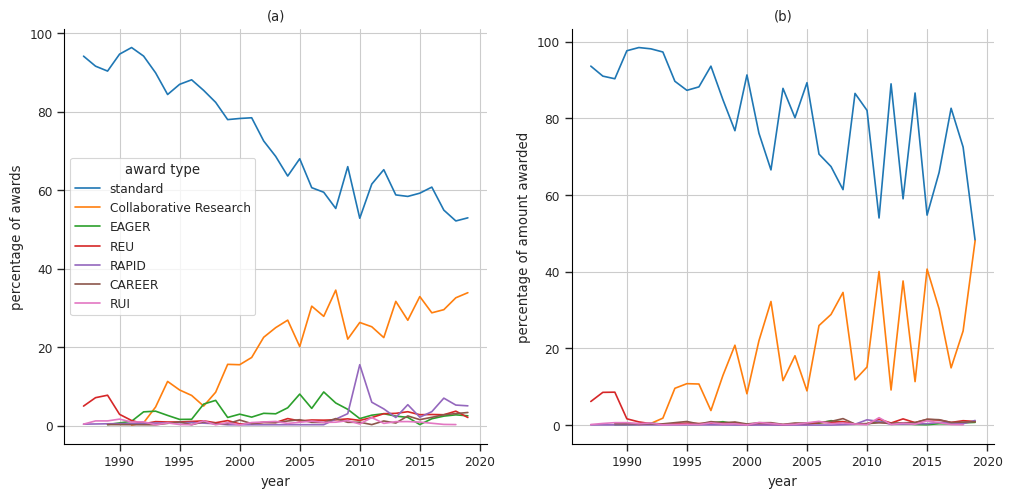

In [13]:
num_awards_per_year = awards.groupby(['year'])['Abstract'].count()
amount_awarded_per_year =  awards.groupby(['year'])['tot_amount_adjusted'].sum()

def smooth(df_in):
    df_out = df_in.set_index(['year','award type']).unstack()
    df_out = df_out.rolling(window=3, center=True).mean().stack()
    return df_out.reset_index()

num_awards = awards_clean.groupby(['year','award_type'])['Abstract'].count().unstack()
pct_num = num_awards[atypes.index].div(num_awards_per_year,axis=0) * 100

amount_awards = awards_clean.groupby(['year','award_type'])['tot_amount_adjusted'].sum().unstack()
pct_amount = amount_awards[atypes.index].div(amount_awarded_per_year, axis=0) * 100

atypes_pct_year = pd.DataFrame([pct_num.stack(), pct_amount.stack()]).transpose()
atypes_pct_year = atypes_pct_year.reset_index().rename(columns={'award_type':'award type', 0:'pct number', 1:'pct amount'})

# atypes_pct_year = smooth(atypes_pct_year)

fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12,5.5))
_ = sns.lineplot(data=atypes_pct_year, x='year', y='pct number', hue='award type', hue_order=atypes.index, ax=axs[0])
_ = axs[0].set(ylabel='percentage of awards', title='(a)')
_ = sns.lineplot(data=atypes_pct_year, x='year', y='pct amount', hue='award type', hue_order=atypes.index, ax=axs[1],
                 legend=False)
_ = axs[1].set(ylabel='percentage of amount awarded', title='(b)')

sns.despine(fig)
fig.savefig('figures/atypes_tseries.png',dpi=dpi,bbox_inches='tight')

Box whisker plots of award (project) size across different NSF-OCE programs (a), research topics (b) and award types (c). Amounts are adjusted for inflation to 2019 U.S. dollars.

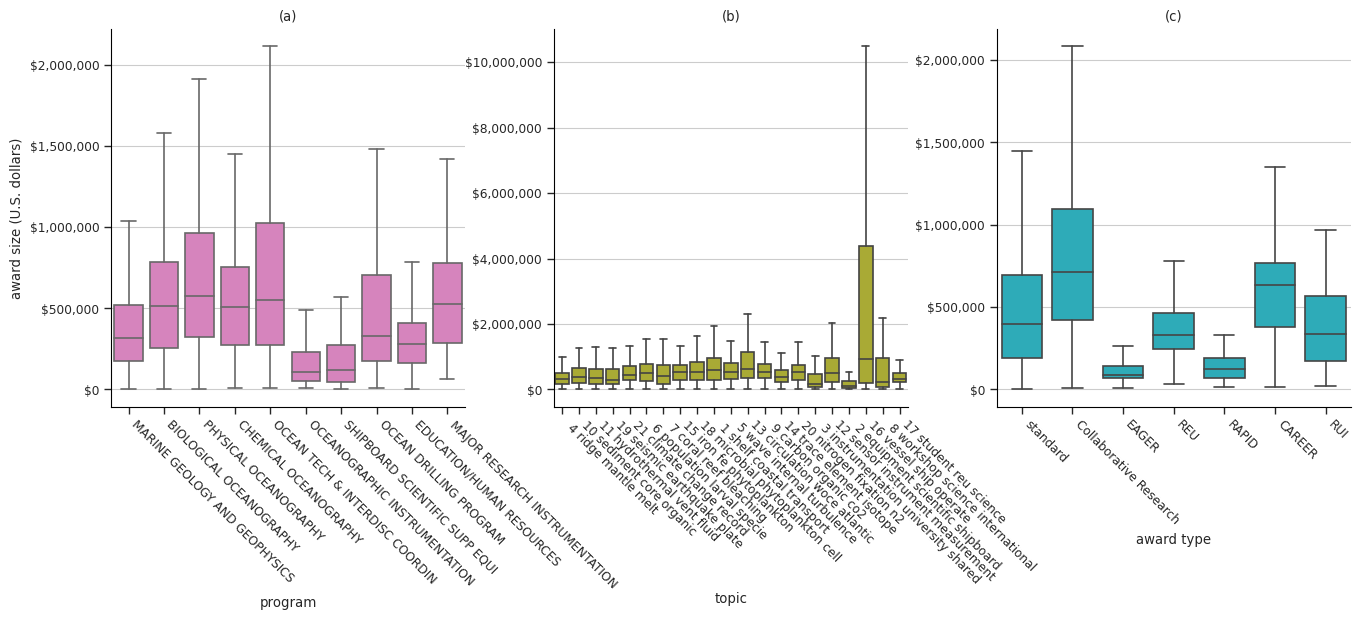

In [14]:
from matplotlib import ticker
def dollar(x, pos):
    return '${:,.0f}'.format(x)

fmt = ticker.FuncFormatter(dollar)
topic_order = np.array([4,10,11,19,21,6,7,15,18,1,5,13,9,14,20,3,12,2,16,8,17]) # order topics by program

fig, axs = plt.subplots(1, 3, figsize=(16,5))
fig.subplots_adjust(wspace=0.25)

_ = sns.boxplot(data=awards_top10, x='program', y='tot_amount_adjusted', showfliers=False,
                order=top10_programs.index, ax=axs[0], color='C6')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = axs[0].set(ylabel='award size (U.S. dollars)', title='(a)')
_ = axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-45, ha='left')

_ = sns.boxplot(data=awards, x='topic', y='tot_amount_adjusted', showfliers=False,
                orient='v', order=topic_order, ax=axs[1], color='C8')
_ = axs[1].set(xticklabels=topic_names_r[topic_order-1])
_ = axs[1].yaxis.set_major_formatter(fmt)
_ = axs[1].set(ylabel='', title='(b)')
_ = axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=-45, ha='left')

_ = sns.boxplot(data=awards_clean, x='award_type', y='tot_amount_adjusted', showfliers=False,
                order=atypes.index, ax=axs[2], color='C9')
_ = axs[2].yaxis.set_major_formatter(fmt)
_ = axs[2].set(ylabel='', xlabel='award type', title='(c)')
_ = axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=-45, ha='left')

sns.despine(fig)
fig.savefig('figures/boxplot_program_topic_atype.png',dpi=dpi,bbox_inches='tight')

Violin plots of the number of co-PIs (team size) across different NSF-OCE programs (a), research topics (b) and award types (c). The dashed and dotted lines inside the violins represent the quartiles of the distribution.

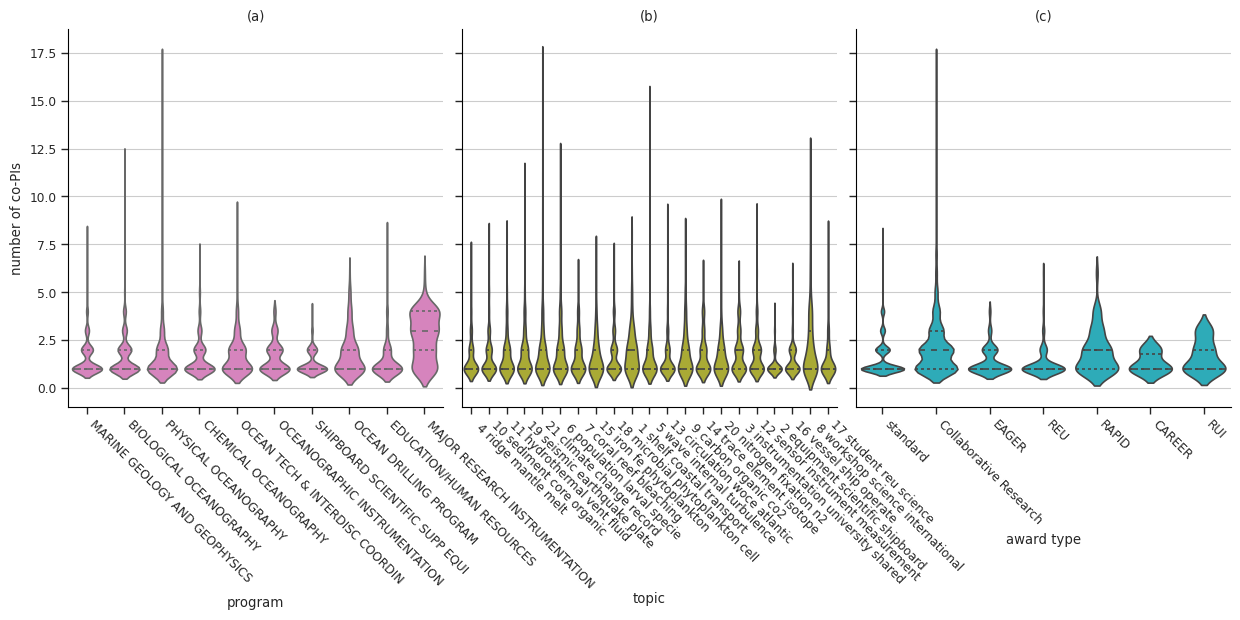

In [15]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
fig.subplots_adjust(wspace=0.05)

_ = sns.violinplot(data=awards_top10, x='program', y='num_co-PIs', showfliers=False,
                   inner='quartile', order=top10_programs.index, scale='width', ax=axs[0], color='C6')
_ = axs[0].set(ylabel='number of co-PIs', title='(a)')
_ = axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-45, ha='left')

_ = sns.violinplot(data=awards, x='topic', y='num_co-PIs', showfliers=False, orient='v',
                   inner='quartile', order=topic_order, scale='width', ax=axs[1], color='C8')
_ = axs[1].set(xticklabels=topic_names_r[topic_order-1])
_ = axs[1].set(ylabel='', title='(b)')
_ = axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=-45, ha='left')

_ = sns.violinplot(data=awards_clean, x='award_type', y='num_co-PIs', showfliers=False,
                   inner='quartile', order=atypes.index, scale='width', ax=axs[2], color='C9')
_ = axs[2].set(ylabel='', xlabel='award type', title='(c)')
_ = axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=-45, ha='left')

sns.despine(fig)
fig.savefig('figures/violinplot_program_topic_atype.png',dpi=dpi,bbox_inches='tight')

Box whisker plot (a) and probability density function (b) of the award size by PI gender. The green triangles in the box whisker plot and the vertical lines in the probability density function plot represent the means for men and women PIs. The award size (X axis) in the probability density function plot is in a log 10 scale. A t-test shows that the difference between the means for women and men PIs is not statistically significant with a t-statistic of 0.452 and  p-value of 0.651. Amounts are adjusted for inflation to 2019 U.S. dollars.

T-test for equal means: t=0.452, p=0.651, df=11415


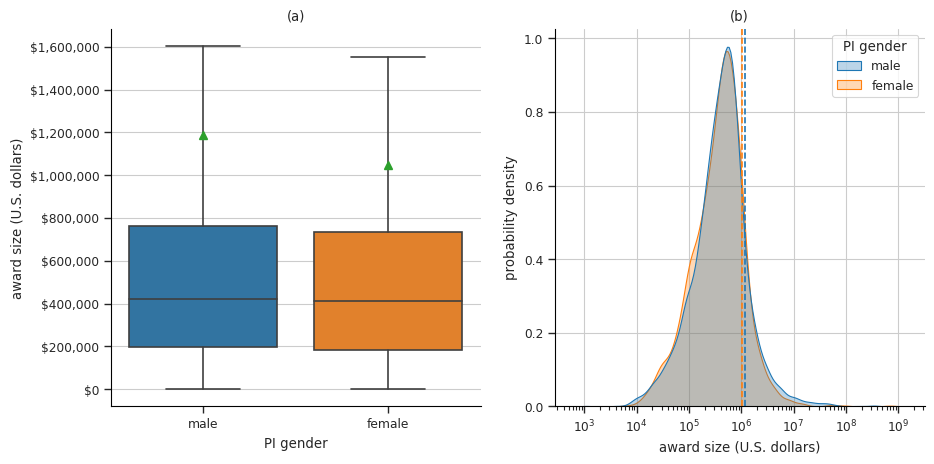

In [16]:
means = awards.groupby('PI_gender')['tot_amount_adjusted'].mean()
mean_men = means['male']
mean_women = means['female']

fig, axs = plt.subplots(1, 2, figsize=(10.5,5))
_ = sns.boxplot(data=awards, x='PI_gender', y='tot_amount_adjusted', showfliers=False, showmeans=True, ax=axs[0])
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = axs[0].set(xlabel='PI gender', ylabel='award size (U.S. dollars)', title='(a)')
df = awards[awards.tot_amount_adjusted>1000]
_ = sns.kdeplot(data=df, x='tot_amount_adjusted', log_scale=True, hue='PI_gender', common_norm=False, fill=True, alpha=0.3, ax=axs[1])
_ = axs[1].legend_.set_title('PI gender')
_ = axs[1].set(xlabel='award size (U.S. dollars)', ylabel='probability density', title='(b)')
_ = axs[1].axvline(mean_men, c='C0', ls='--')
_ = axs[1].axvline(mean_women, c='C1', ls='--')

sns.despine(ax=axs[0])
sns.despine(ax=axs[1])
fig.savefig('figures/award_size_pi_gender.png',dpi=dpi,bbox_inches='tight')

awards_male = awards[awards.PI_gender == 'male'][['year','tot_amount_adjusted']]
awards_female = awards[awards.PI_gender == 'female'][['year','tot_amount_adjusted']]
tstat, pval, df = sm.stats.ttest_ind(awards_male.tot_amount_adjusted.values, awards_female.tot_amount_adjusted.values)
print('T-test for equal means: t={:.3f}, p={:.3f}, df={:.0f}'.format(tstat, pval, df))

Probability density function (PDF) of the percentage of women co-PIs (a) and number of co-PIs (b) by PI gender. The vertical lines represent the means for women and men PIs. In both cases, the PDF for women PIs is more heavy-tailed than that of men towards higher values, resulting in a larger mean for women PIs. A t-test shows that the difference between the mean percentage of women co-PIs for women and men PIs is statistically significant with a t-statistic of 7.764 and a p-value<$10^{-12}$. The difference between the mean number of co-PIs for women and men PIs is small but a t-test shows that it is statistically significant with a t-statistic of 2.668 and a p-value of 0.008.

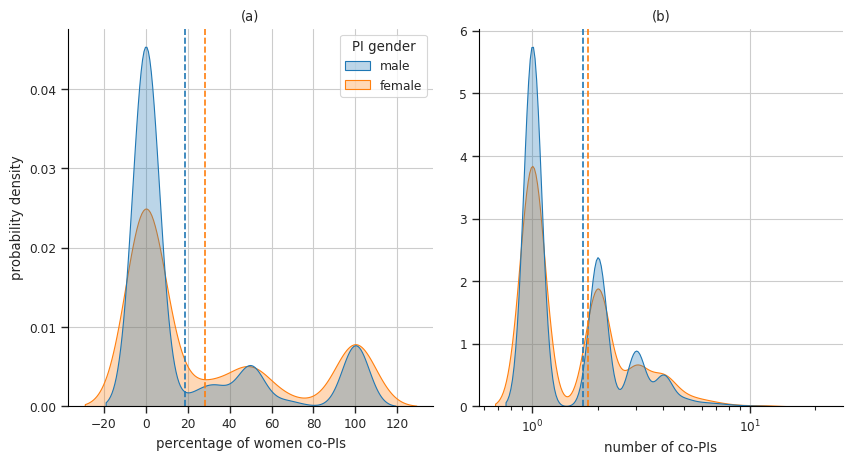

In [17]:
df = awards[awards['co-PI_female_pct'].notna()]

means_female_pct = df.groupby('PI_gender')['co-PI_female_pct'].mean()
means_num_copi = df.groupby('PI_gender')['num_co-PIs'].mean()

fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(wspace=0.125)
_ = sns.kdeplot(data=df, x='co-PI_female_pct', hue='PI_gender', common_norm=False, alpha=0.3, fill=True, ax=axs[0])
_ = axs[0].legend_.set_title('PI gender')
_ = axs[0].set(xlabel='percentage of women co-PIs', ylabel='probability density', title='(a)')
_ = axs[0].axvline(means_female_pct['male'], c='C0', ls='--')
_ = axs[0].axvline(means_female_pct['female'], c='C1', ls='--')

_ = sns.kdeplot(data=df, x='num_co-PIs', hue='PI_gender', common_norm=False, alpha=0.3, fill=True, legend=False,
                ax=axs[1], log_scale=True)
_ = axs[1].set(xlabel='number of co-PIs', ylabel='', title='(b)')
_ = axs[1].axvline(means_num_copi['male'], c='C0', ls='--')
_ = axs[1].axvline(means_num_copi['female'], c='C1', ls='--')

sns.despine(fig)
fig.savefig('figures/copi_pct_kde.png',dpi=dpi,bbox_inches='tight')

In [18]:
awards_with_copis = awards[awards['num_co-PIs'].notnull()]
df_male = awards_with_copis[awards_with_copis.PI_gender=='male']
df_female = awards_with_copis[awards_with_copis.PI_gender=='female']

male = df_male['co-PI_female_pct'].dropna().values
female = df_female['co-PI_female_pct'].dropna().values
tstat, pval, df = sm.stats.ttest_ind(male, female)
print(means_female_pct)
print('T-test for equal means: t={:.3f}, p={:.6f}, df={:.0f}\n'.format(tstat, pval, df))

male = df_male['num_co-PIs'].dropna().values
female = df_female['num_co-PIs'].dropna().values
tstat, pval, df = sm.stats.ttest_ind(male, female)
print(means_num_copi)
print('T-test for equal means: t={:.3f}, p={:.3f}, df={:.0f}\n'.format(tstat, pval, df))

PI_gender
female    28.099913
male      18.917151
Name: co-PI_female_pct, dtype: float64
T-test for equal means: t=-7.764, p=0.000000, df=5726

PI_gender
female    1.812050
male      1.706889
Name: num_co-PIs, dtype: float64
T-test for equal means: t=-2.668, p=0.008, df=5730

